In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


Resnet152

In [3]:
# Essential Libraries
import os
import tarfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, UpSampling2D
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [4]:
# Unpacking files
input_dir = '/kaggle/input/brats-2021-task1'
extracted_data_path = '/kaggle/working/BraTS2021_Training_Data'

# Check if the data is already extracted, if not, extract it
if not os.path.exists(extracted_data_path):
    os.makedirs(extracted_data_path, exist_ok=True)
    for file_name in os.listdir(input_dir):
        if file_name.endswith(".tar"):
            file_path = os.path.join(input_dir, file_name)
            with tarfile.open(file_path) as tar:
                tar.extractall(path=extracted_data_path)


In [5]:
# Import nibabel for loading .nii.gz files
import nibabel as nib

# Function to load and preprocess NIfTI images
def load_nii_image(path, image_size=(224, 224)):
    nii_img = nib.load(path)
    img_data = nii_img.get_fdata()  # Get image data as numpy array
    img_data = img_data[:, :, img_data.shape[2] // 2]  # Select middle slice for 2D processing
    img_data = cv2.resize(img_data, image_size)  # Resize to the desired shape
    img_data = np.expand_dims(img_data, axis=-1)  # Make it (224, 224, 1)
    img_data = img_data / np.max(img_data)  # Normalize to [0, 1]
    return img_data

# Loading images and masks
image_data = []
mask_data = []

for patient_folder in tqdm(os.listdir(extracted_data_path)):
    patient_path = os.path.join(extracted_data_path, patient_folder)
    if os.path.isdir(patient_path):
        flair_path = os.path.join(patient_path, f"{patient_folder}_flair.nii.gz")  # Adjust based on naming
        mask_path = os.path.join(patient_path, f"{patient_folder}_seg.nii.gz")  # Adjust based on naming
        
        # Load and preprocess images
        flair_img = load_nii_image(flair_path)
        mask_img = load_nii_image(mask_path)
        
        image_data.append(flair_img)
        mask_data.append(mask_img)

# Convert lists to numpy arrays
image_data = np.array(image_data)
mask_data = np.array(mask_data)


  0%|          | 4/1262 [00:00<05:02,  4.15it/s]/tmp/ipykernel_37/428015953.py:11: RuntimeWarning: invalid value encountered in divide
  img_data = img_data / np.max(img_data)  # Normalize to [0, 1]
100%|██████████| 1262/1262 [04:27<00:00,  4.72it/s]


In [6]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_data, mask_data, test_size=0.2, random_state=42)


In [7]:
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, Conv2D

def build_resnet152_model(input_shape=(224, 224, 1)):
    # Load ResNet152 base model without the top classification layer
    base_model = ResNet152(include_top=False, weights=None, input_shape=input_shape)

    # Adding more upsampling layers to reach the target dimensions
    x = base_model.output

    # Progressive upsampling to restore the spatial dimensions to (224, 224)
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 7x7 -> 14x14
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 14x14 -> 28x28
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 28x28 -> 56x56
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # 56x56 -> 112x112
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # 112x112 -> 224x224

    # Final convolution layer to get a single-channel output with sigmoid activation for binary segmentation
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Define and compile model
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Initialize the model
model = build_resnet152_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      3,200 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 69,369,601 (264.62 MB)

 Trainable params: 69,218,177 (264.05 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [8]:
# Training the model
batch_size = 8
epochs = 5

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=batch_size, 
                    epochs=epochs)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1187s 8s/step - accuracy: 0.8307 - loss: nan - val_accuracy: 0.8604 - val_loss: nan
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1068s 9s/step - accuracy: 0.8369 - loss: nan - val_accuracy: 0.8604 - val_loss: nan
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1065s 8s/step - accuracy: 0.8508 - loss: nan - val_accuracy: 0.8604 - val_loss: nan
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1034s 8s/step - accuracy: 0.8466 - loss: nan - val_accuracy: 0.8604 - val_loss: nan
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1062s 9s/step - accuracy: 0.8450 - loss: nan - val_accuracy: 0.8604 - val_loss: nan


In [9]:
# Model evaluation
model.evaluate(X_val, y_val)


8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.8416 - loss: nan


[nan, 0.8604394793510437]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


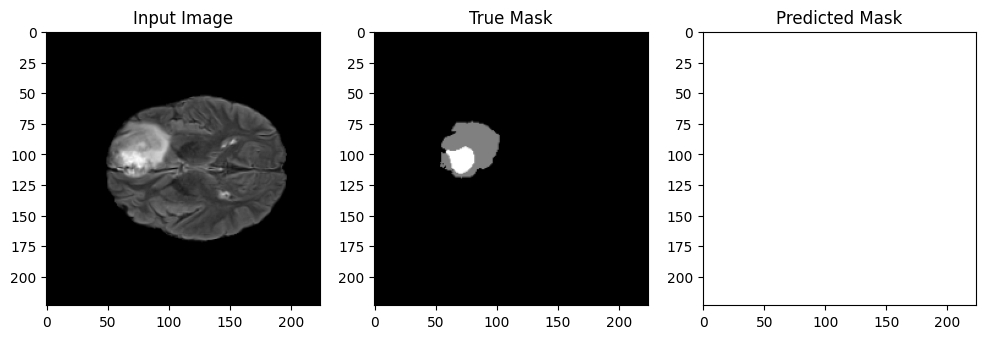

In [10]:
# Predict and visualize sample results
sample_idx = 5  # Choose an index to visualize

pred = model.predict(np.expand_dims(X_val[sample_idx], axis=0))[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(X_val[sample_idx].squeeze(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(y_val[sample_idx].squeeze(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred.squeeze(), cmap="gray")

plt.show()


In [11]:
from tensorflow.keras.losses import BinaryCrossentropy

# Dice loss function
def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2 * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

# Combining Dice loss with Binary Cross-Entropy
def combined_bce_dice_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_bce_dice_loss, metrics=["accuracy"])


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentations
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


In [14]:
# Dice Coefficient Metric
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_bce_dice_loss, metrics=["accuracy", dice_coefficient])


In [15]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

# Use SGD optimizer
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=combined_bce_dice_loss, metrics=["accuracy", dice_coefficient])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(scheduler)


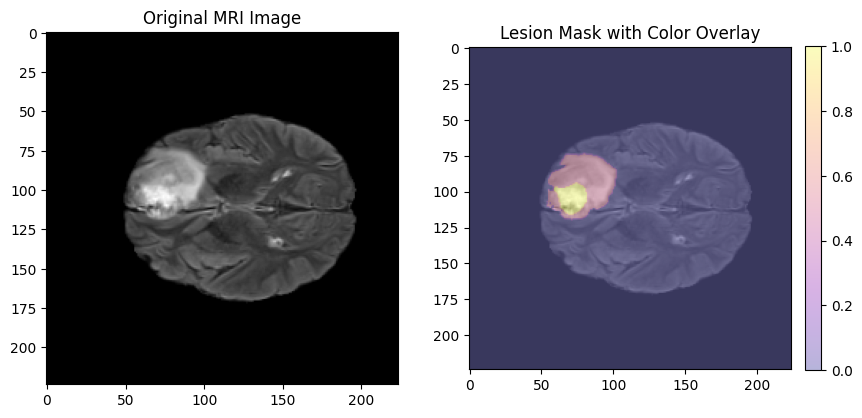

In [16]:
def visualize_with_colormap(image, mask, colormap='jet'):
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title("Original MRI Image")
    plt.imshow(image.squeeze(), cmap="gray")

    # Mask with Colormap Overlay
    plt.subplot(1, 2, 2)
    plt.title("Lesion Mask with Color Overlay")
    color_overlay = plt.imshow(image.squeeze(), cmap="gray", alpha=0.7)
    color_mask = plt.imshow(mask.squeeze(), cmap=colormap, alpha=0.3)
    plt.colorbar(color_mask, fraction=0.046, pad=0.04)

    plt.show()

# Example use with a sample
sample_idx = 5
visualize_with_colormap(X_val[sample_idx], y_val[sample_idx], colormap='plasma')
